In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def pulse(t, freq=1, phase=0, treshhold=0.5):
    return 1 + np.sin(np.pi*freq*t + phase) < treshhold

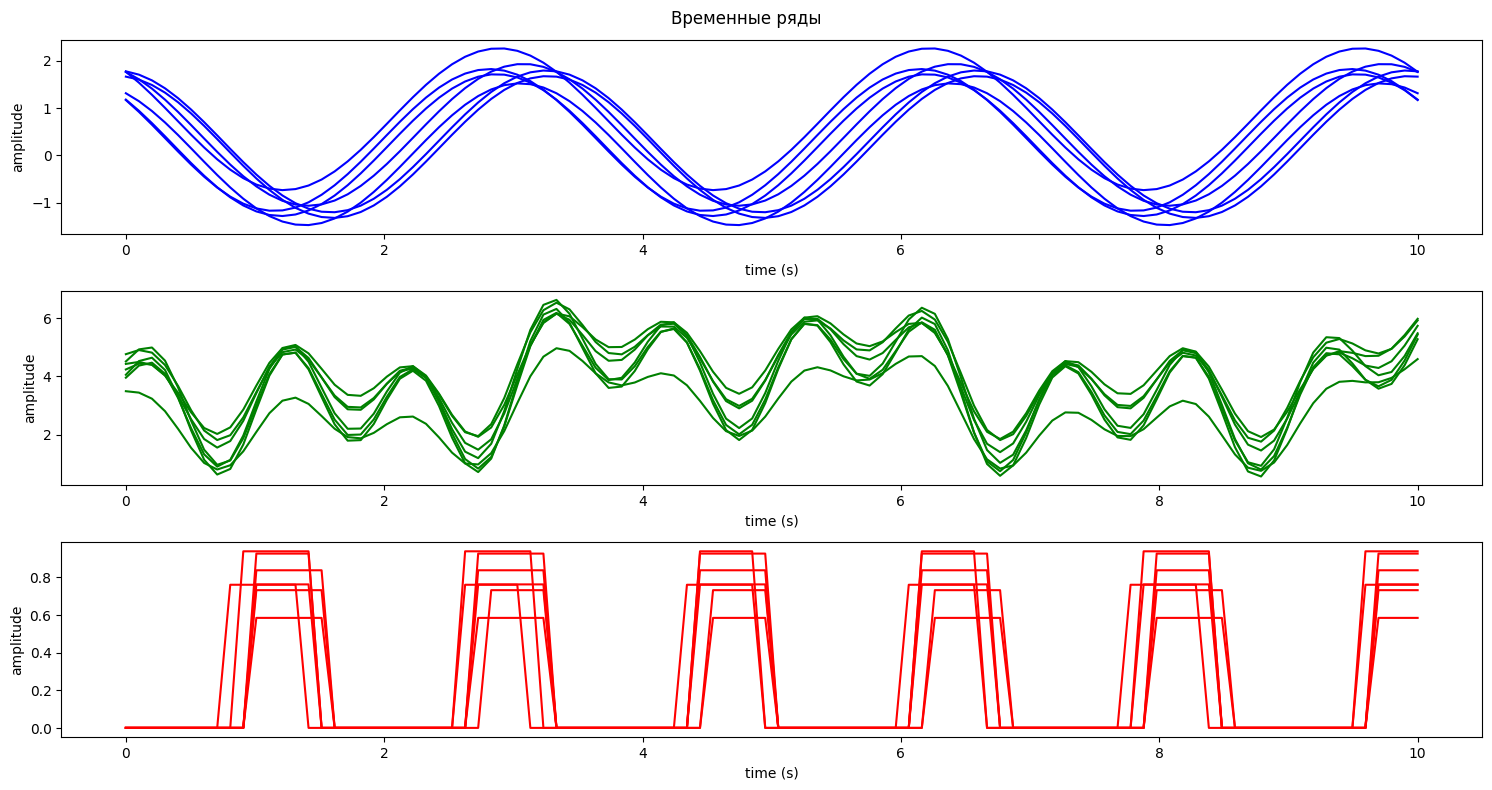

In [3]:
duration = 10 # sec
N = 7
num_samples = 100
time_index = np.linspace(0, duration, num_samples)

data = {'Time': time_index}


# Группа косинусов
for i in range(N):
    data["Cosinus-"+str(i+1)]= 1.5*np.cos(0.6*np.pi*time_index + np.random.random()) + np.random.random()

# Группа модифицированных синусов
for i in range(N):
    data["Sinus-"+str(i+1)] = 1.6*np.sin(np.pi*np.sin(np.pi + time_index) + 0.4*np.random.random()) + \
                              np.sin(2*np.pi*time_index)*(np.random.random() + 0.65) + \
                              1.7*np.random.random() + 3
    
    # Группа модифицированных синусов
for i in range(N):
    data["Pulse-"+str(i+1)] = np.random.uniform(0.5, 1)*pulse(time_index, 1.15, np.random.random(), 0.5)

# Графики
fig, axs = plt.subplots(3, 1,figsize=(15, 8))
for i in range(N):
    axs[0].plot(time_index, data["Cosinus-"+str(i+1)], '-b')
for i in range(N):
    axs[1].plot(time_index, data["Sinus-"+str(i+1)], '-g')
for i in range(N):
    axs[2].plot(time_index, data["Pulse-"+str(i+1)], '-r')


fig.suptitle(r'Временные ряды')
axs[0].set_xlabel(r'time (s)')
axs[0].set_ylabel(r'amplitude')
axs[1].set_xlabel(r'time (s)')
axs[1].set_ylabel(r'amplitude')
axs[2].set_xlabel(r'time (s)')
axs[2].set_ylabel(r'amplitude')
fig.tight_layout(pad=1.0)

In [4]:
def compute_distance_matrix(x, y, q) -> np.array:
    dist = np.zeros((len(y), len(x)))
    for i in range(len(y)):
        for j in range(len(x)):
            dist[i,j] = (x[j]-y[i])**q
    return dist

In [5]:
def DTW(x, y, q, isDTW=True):
    Nx = len(x)
    Ny = len(y)

    # Находим матрицу расстояний
    dist = compute_distance_matrix(x, y, q)

    # Инициализируем нулевые значения рекуррентной матрицы R
    R = [[0] * (Nx) for i in range(Ny)]

    for i in range(1, Nx): 
        R[0][i] = dist[0, i] + R[0][i-1]
    for j in range(1, Ny):
        R[j][0] = dist[j, 0] + R[j-1][0]
    
    # Рассчитываем R
    k = 1 if isDTW else 0

    for i in range(1, Ny): 
        for j in range(1, Nx):
            R[i][j] = dist[i-1,j-1] + k*np.min([R[i-1][j], R[i][j-1], R[i-1][j-1]]) 

    # Ищем минимальный путь 
    path = []
    i = Ny - 1
    j = Nx - 1
    while i >= 0 and j >= 0:
        path.append((i, j))
        if R[i][j-1] < R[i-1][j-1] and R[i][j-1] < R[i-1][j]:
            I = i
            J = j-1                
        elif R[i-1][j] < R[i-1][j-1]:
            I = i - 1
            J = j 
        else:
            I = i - 1
            J = j - 1
        i = I
        j = J

    #Считаем расстояние
    s = 0
    for i, j in path:
        s += R[i][j]
    s = s / len(path) 

    return s, path, R


In [6]:
y_sin1 = np.abs(data["Sinus-1"])
y_sin2 = np.abs(data["Sinus-2"])
y_cos4 = np.abs(data["Cosinus-4"])
y_cos7 = np.abs(data["Cosinus-7"])
y_pulse1 = np.abs(data["Pulse-1"])
s1 = DTW(y_sin1, y_sin2, q=2)
s2 = DTW(y_sin1, y_cos4, q=2)
s3 = DTW(y_sin1, y_pulse1, q=2)
s4 = DTW(y_cos4, y_cos7, q=2)
 
print (f"With DTW\nSinus-1 <-> Sinus-2 = {s1[0]}\nSinus-1 and Cosinus-4 = {s2[0]}\nSinus-1 and Pulse-1 = {s3[0]}\nCosinus-4 and Cosinus-7 = {s4[0]}\n")

s11 = DTW(y_sin1, y_sin2, q=2, isDTW=False)
s21 = DTW(y_sin1, y_cos4, q=2, isDTW=False)
s31 = DTW(y_sin1, y_pulse1, q=2, isDTW=False)
s41 = DTW(y_cos4, y_cos7, q=2, isDTW=False)

print (f"Dec\nSinus-1 <-> Sinus-2 = {s11[0]}\nSinus-1 and Cosinus-4 = {s21[0]}\nSinus-1 and Pulse-1 = {s31[0]}\nCosinus-4 and Cosinus-7 = {s41[0]}")

With DTW
Sinus-1 <-> Sinus-2 = 17.49211126244727
Sinus-1 and Cosinus-4 = 276.60794137695285
Sinus-1 and Pulse-1 = 641.6663290093461
Cosinus-4 and Cosinus-7 = 1.1457041323875548

Dec
Sinus-1 <-> Sinus-2 = 2.6950407733918955
Sinus-1 and Cosinus-4 = 7.289725673088938
Sinus-1 and Pulse-1 = 7.189927751904872
Cosinus-4 and Cosinus-7 = 0.03974621560179598


In [7]:
import seaborn as sbn

def draw_cost_matrix(s):
    cost_matrix = s[2]
    warp_path = s[1]

    fig, ax = plt.subplots(figsize=(18, 10))
    ax = sbn.heatmap(cost_matrix, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)
    ax.invert_yaxis()


    path_x = [p[0]+0.5 for p in warp_path]
    path_y = [p[1]+0.5 for p in warp_path]

    ax.plot(path_x, path_y, color='blue', linewidth=3, alpha=0.2)

def draw_corr_lines(ts1, ts2, s):
    fig, ax = plt.subplots(figsize=(18, 5))

    warp_path = s[1]

    # Remove the border and axes ticks
    fig.patch.set_visible(True)
    ax.axis('off')

    for i, j in warp_path:   
        ax.plot([i, j], [ts2[i], ts1[j]], '-k', alpha=0.5)

    ax.plot(ts1, color='blue', marker='o', markersize=5)
    ax.plot(ts2, color='red', marker='o', markersize=5)
    ax.tick_params(axis="both", which="major", labelsize=18)

## Весовые карты с DTW

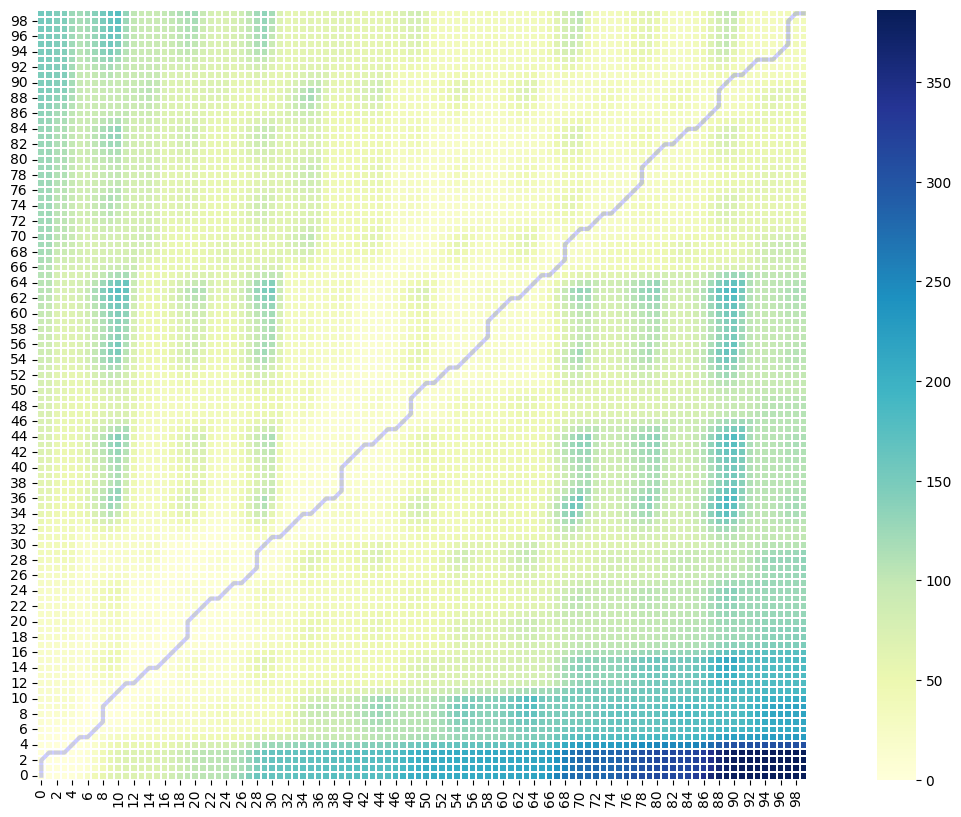

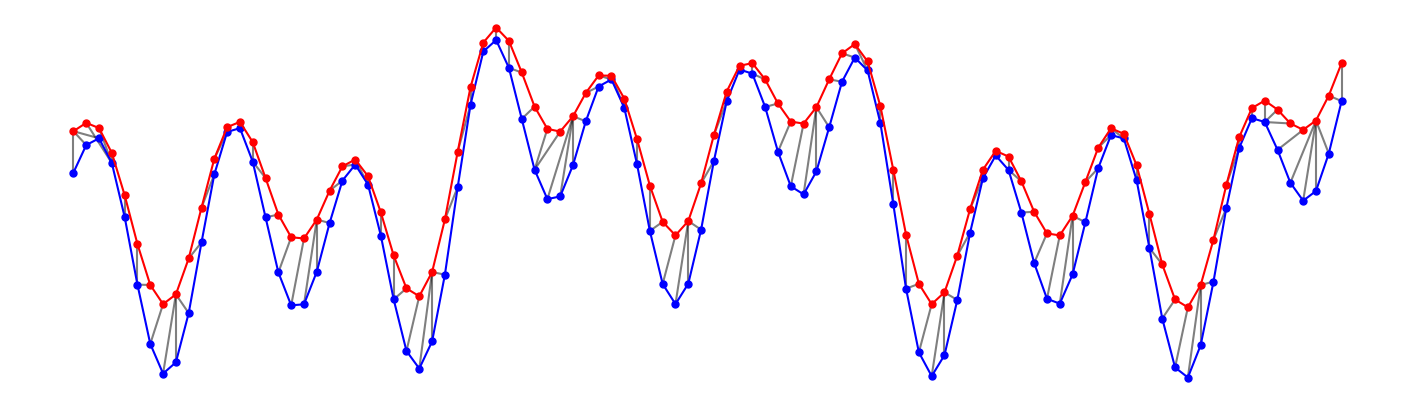

In [14]:
draw_cost_matrix(s1)
draw_corr_lines(y_sin1, y_sin2, s1)

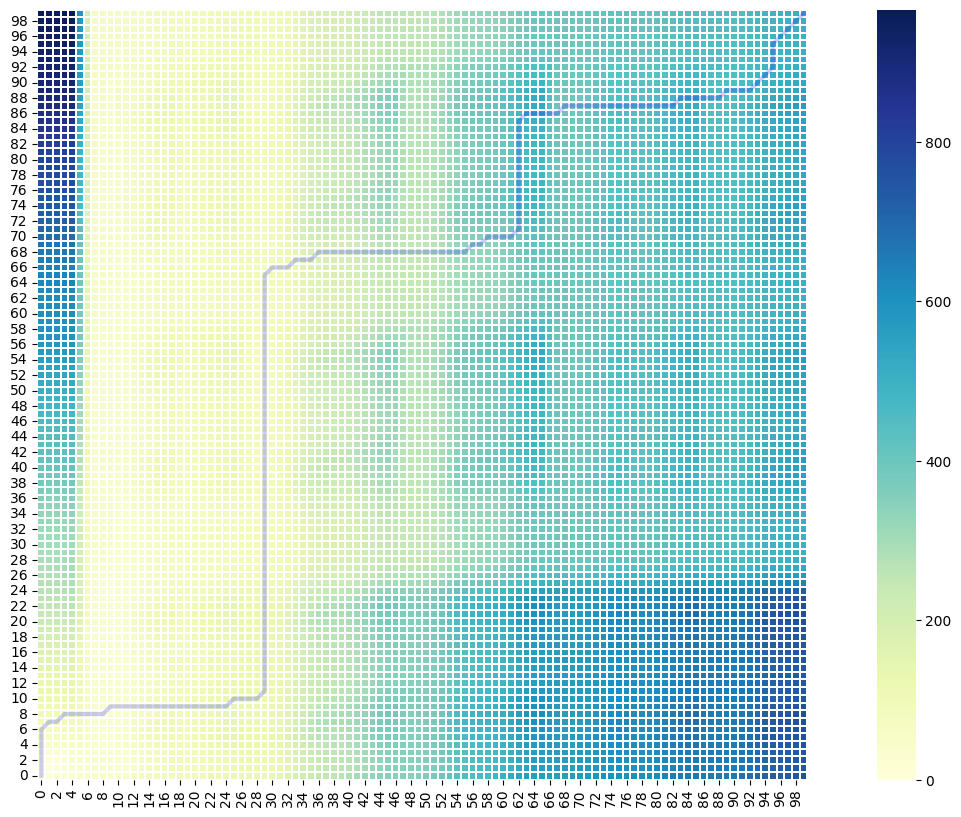

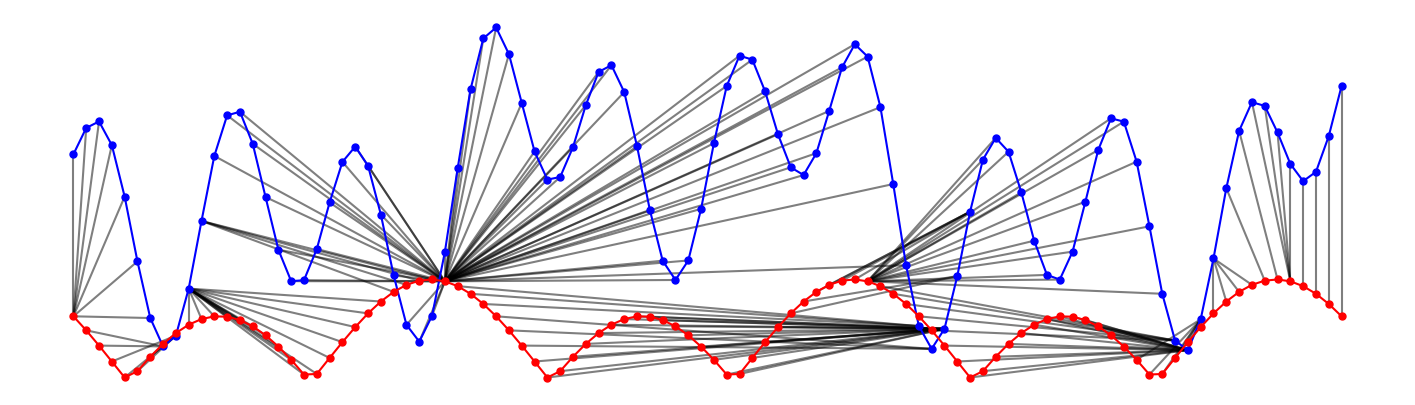

In [15]:
draw_cost_matrix(s2)
draw_corr_lines(y_sin1, y_cos4, s2)

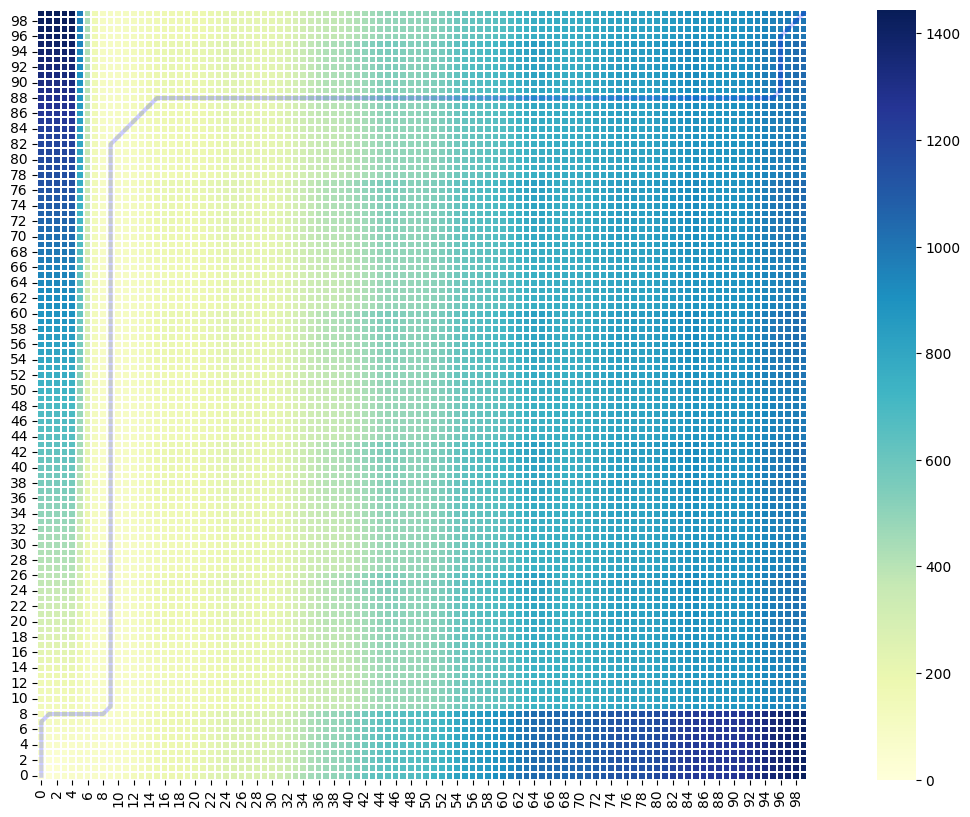

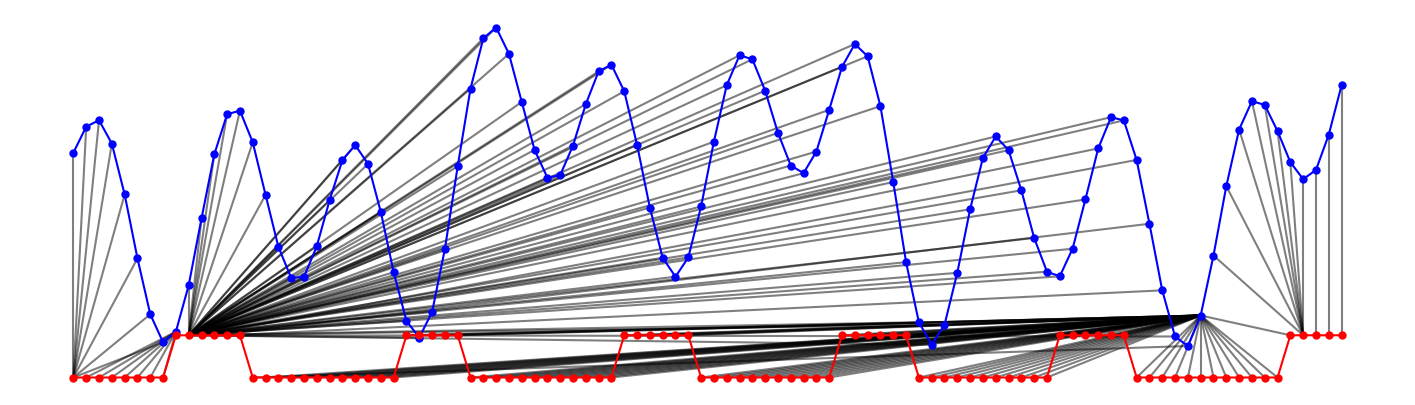

In [16]:
draw_cost_matrix(s3)
draw_corr_lines(y_sin1, y_pulse1, s3)

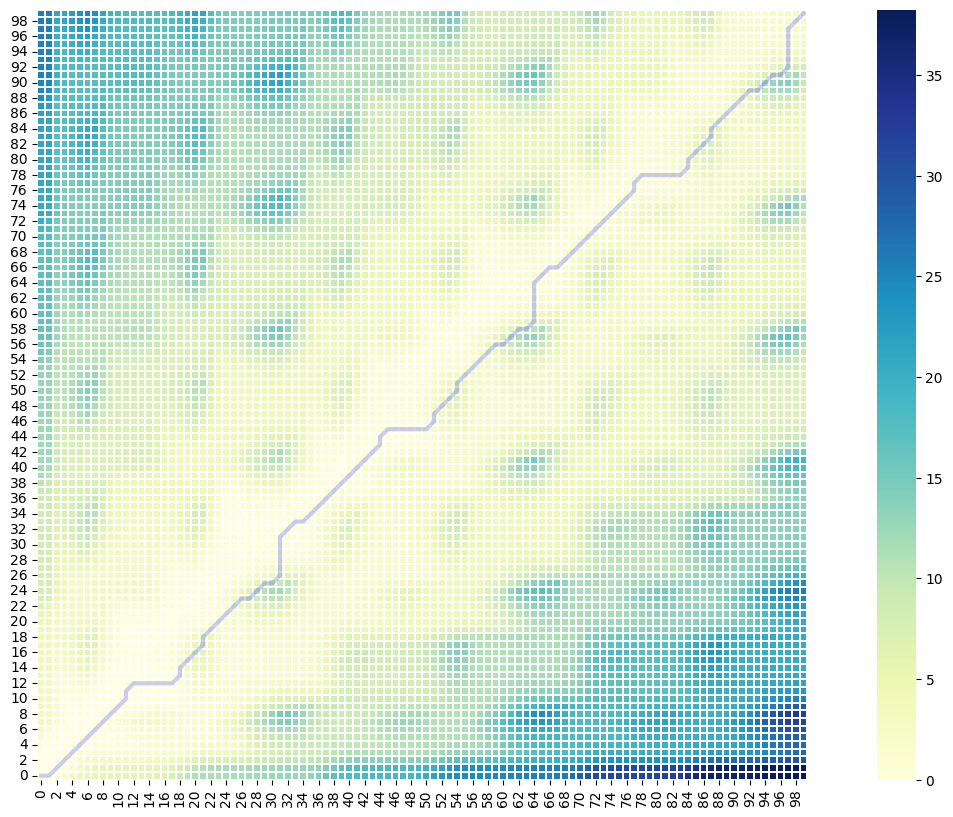

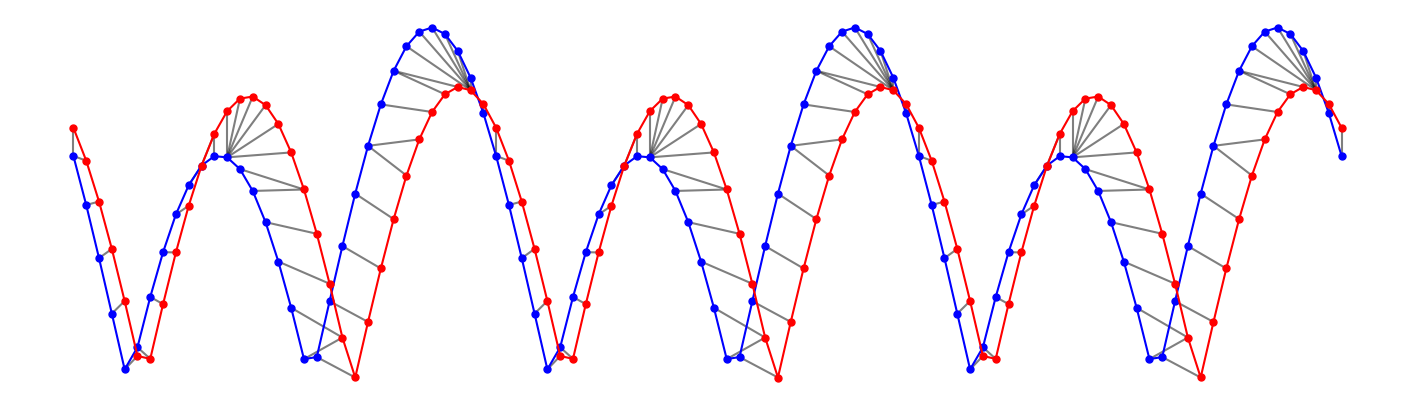

In [18]:
draw_cost_matrix(s4)
draw_corr_lines(y_cos4, y_cos7, s4)

## Весовые карты без DTW

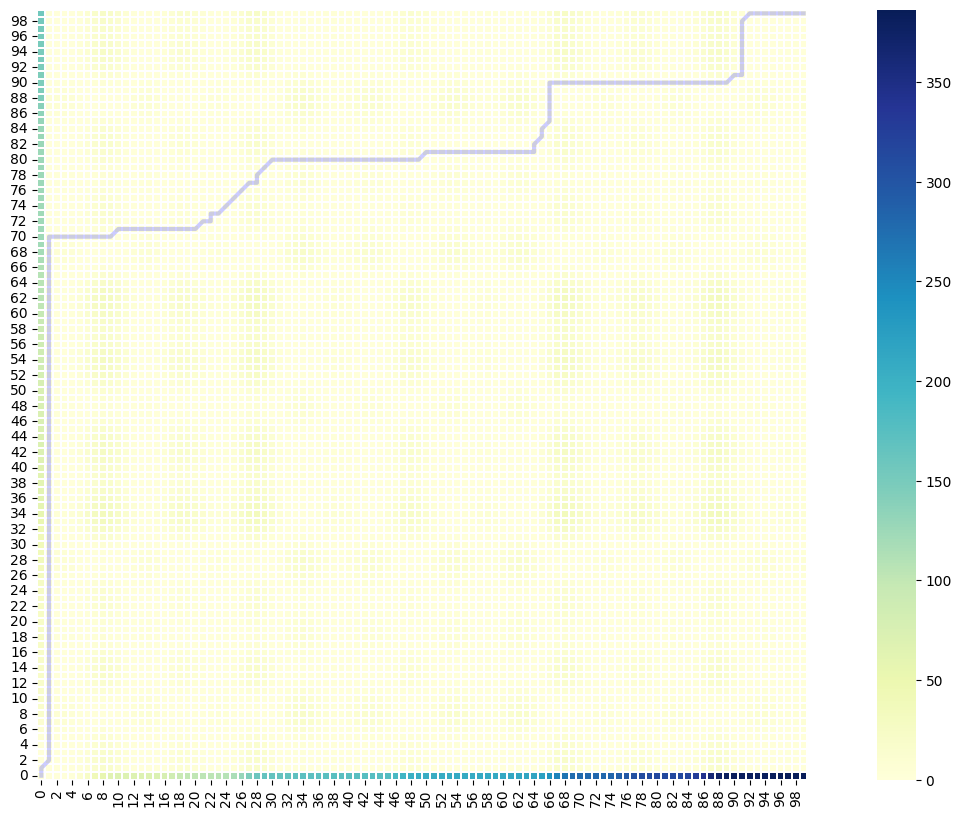

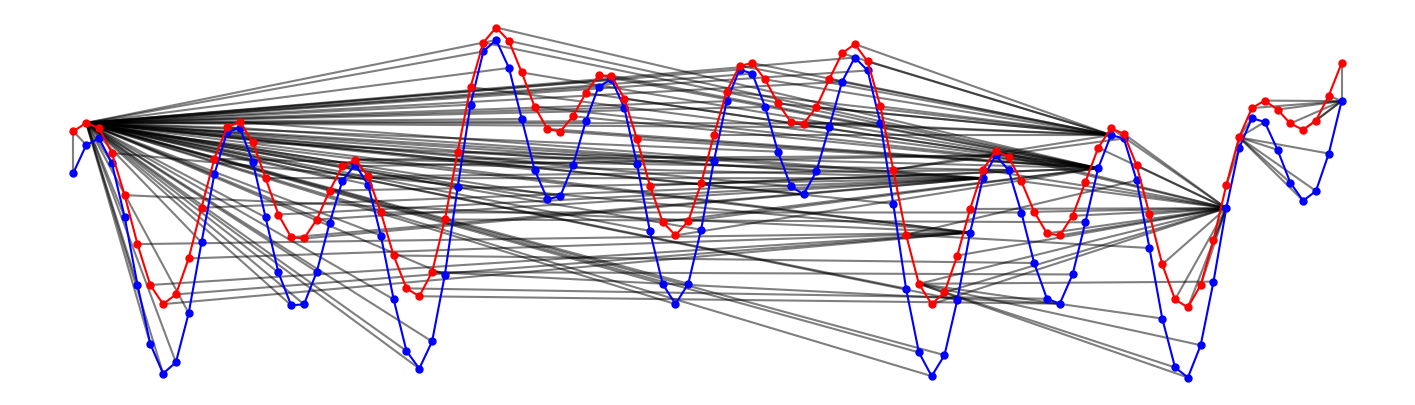

In [19]:
draw_cost_matrix(s11)
draw_corr_lines(y_sin1, y_sin2, s11)

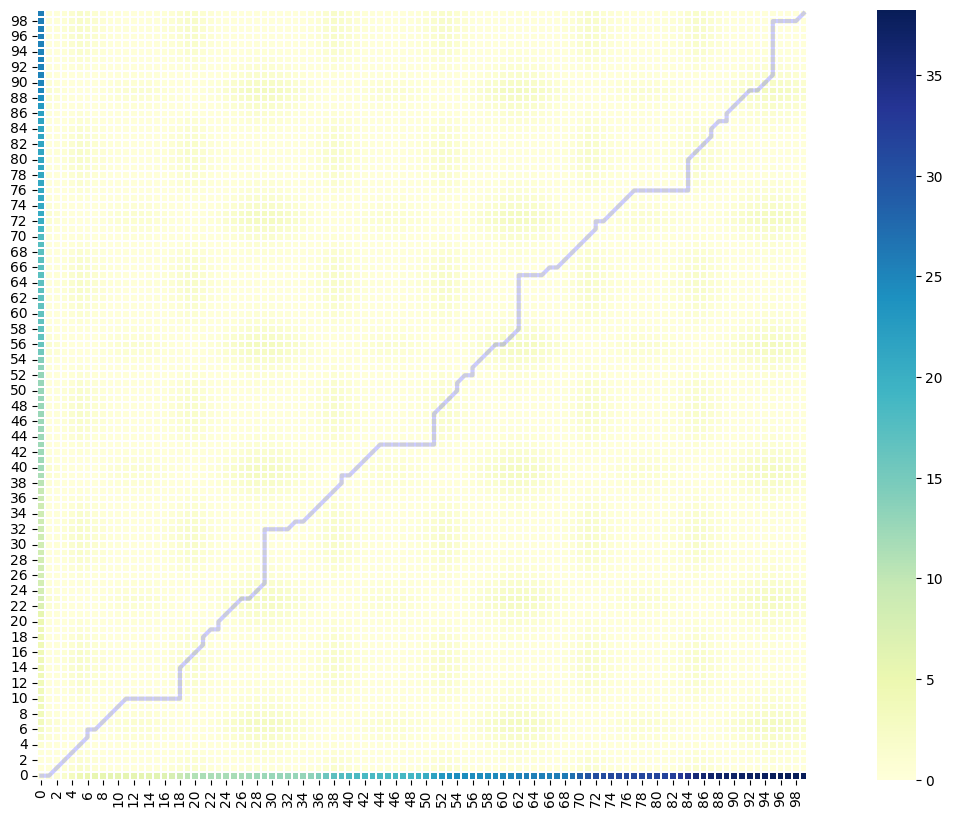

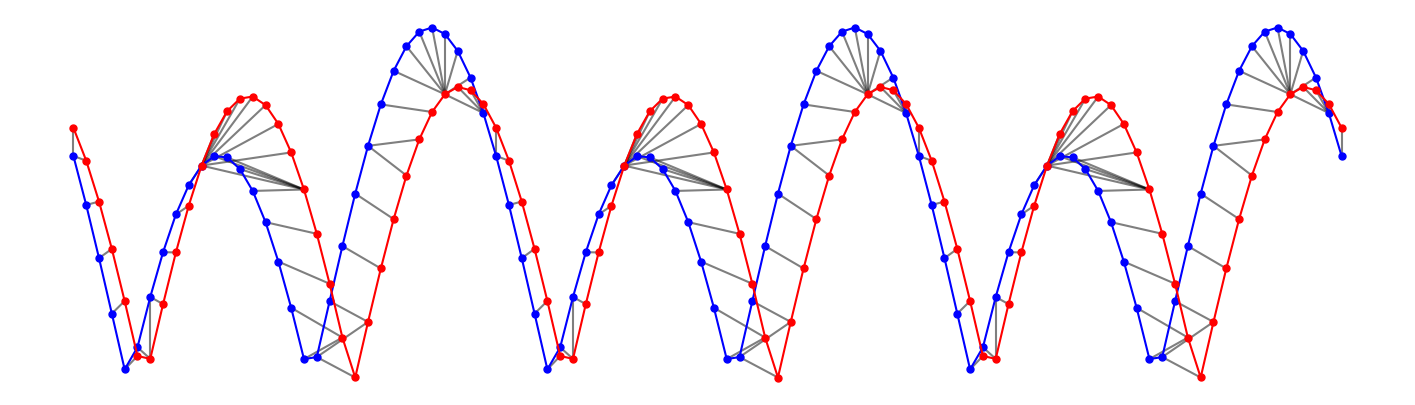

In [22]:
draw_cost_matrix(s41)
draw_corr_lines(y_cos4, y_cos7, s41)

## Вычисление с помощью встроенных функций

In [26]:
from dtaidistance import dtw

y_sin3 = np.abs(data["Sinus-3"])
y_sin7 = np.abs(data["Sinus-7"])


distance, paths = dtw.warping_paths(y_sin3, y_sin7)
print(distance)
print(paths)

2.6000645931754143
[[ 0.                 inf         inf ...         inf         inf
          inf]
 [        inf  0.1908471   0.32172441 ... 11.59891978 11.65854565
  11.78706917]
 [        inf  0.1910533   0.19984318 ... 11.47004649 11.51165574
  11.61370019]
 ...
 [        inf 13.49309797 13.49021806 ...  2.59818866  2.7484697
   3.10968655]
 [        inf 13.50756733 13.50170755 ...  2.56932415  2.59465991
   2.75293553]
 [        inf 13.57046609 13.55824565 ...  2.68609474  2.58896562
   2.60006459]]


In [ ]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import random
import numpy as np

yw = np.arange(0, 20, .5)
s1 = x
s2 = x_s
random.seed(1)
for idx in range(len(s2)):
    if random.random() < 0.05:
        s2[idx] += (random.random() - 0.5) / 2
d, paths = dtw.warping_paths(s1, s2, window=25, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path)